# Correlating field data with canopy cover

**Tl;dr**

- The angle and distance data do not seem to explain much of the canopy cover
- The polynomial data doesn't seem to add much prediction power either


- Drone data does improve predicting power.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

# Load the data

`merged_data.csv` is a single file with all the field measurements.
- Yield and harvest data
- Field data
- Angle and distance data
- Drone data
- Polynomial modeling data

A total of 368 samples (out of 500) report values for all measurements
- Samples with missing data were discarded

In [2]:
src = '../2019_G2F_Shared/'
dst = '../model/field_data/'

data_file = 'merged_data.csv'

data = pd.read_csv(src + data_file)
print(data.shape)

(368, 220)


## Measure correlation

- Check both Pearson and Spearman correlation for all measurements
- Angle, distance, and polynomial data is located at the bottom, right corner
    - These measurements only seem to correlate among themselves

In [3]:
pcorr = data.iloc[:,19:].corr(method='pearson')
scorr = data.iloc[:,19:].corr(method='spearman')

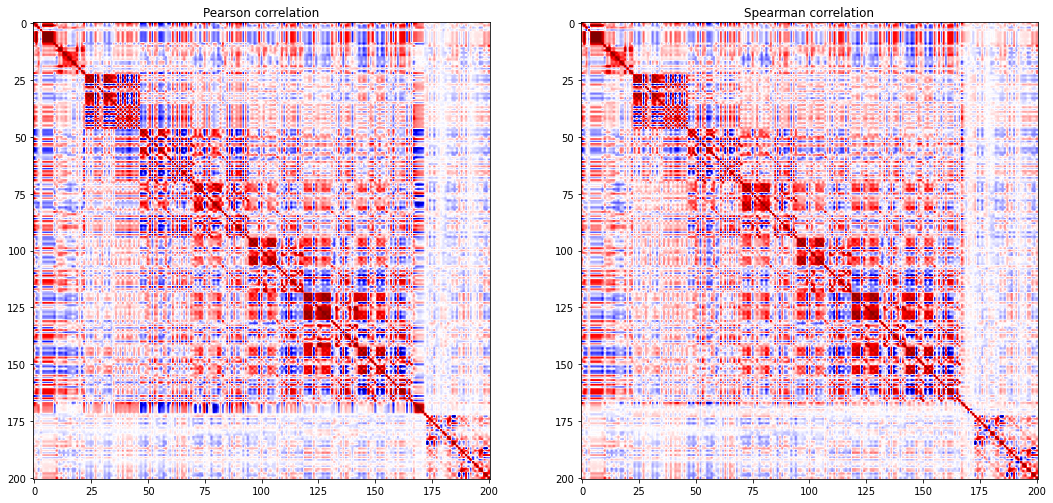

In [4]:
cmap = 'seismic'
vmax,vmin = 1,-1

fig, ax = plt.subplots(1,2,figsize=(18,9))

i = 0
ax[i].imshow(np.array(pcorr), cmap=cmap, vmax=vmax, vmin=vmin)
ax[i].set_title('Pearson correlation')

i = 1
ax[i].imshow(np.array(scorr), cmap=cmap, vmax=vmax, vmin=vmin)
ax[i].set_title('Spearman correlation');

In [5]:
# List of all measurements

for i,c in enumerate(scorr.columns):
    print(i, '\t', c)

0 	 canopy_cover
1 	 Weight
2 	 Moisture
3 	 Test.Weight
4 	 yield_originaal_moisture
5 	 yield_dry
6 	 yield_standard
7 	 yield_standard_bu
8 	 yield_dry_gm
9 	 dry_matter/plant(kg)
10 	 Ear_Leaf_Length (cm)
11 	 Ear_Leaf_Width (cm)
12 	 Ear_Leaf_Area (cm^2)
13 	 Ear_Height (cm)
14 	 Plant_Height (cm)
15 	 Ear_Leaf_N
16 	 Total_Leaf_N
17 	 AnthesisGDD
18 	 SilkingGDD
19 	 TLA (m2)
20 	 epd
21 	 ear_leaf_weight (g)
22 	 LAI
23 	 BLUE_2019702dronemean
24 	 BLUE_STD_2019702dronemean
25 	 GREEN_2019702dronemean
26 	 GREEN_STD_2019702dronemean
27 	 NDVI_2019702dronemean
28 	 NDVI_STD_2019702dronemean
29 	 NIR_2019702dronemean
30 	 NIR_STD_2019702dronemean
31 	 RED_2019702dronemean
32 	 RED_STD_2019702dronemean
33 	 RED_EDGE_2019702dronemean
34 	 RED_EDGE_STD_2019702dronemean
35 	 BGI_72_mean_2019702dronemean
36 	 BGI_72_STD_2019702dronemean
37 	 EVI_72_mean_2019702dronemean
38 	 EVI_72_STD_2019702dronemean
39 	 GNDVI_72_mean_2019702dronemean
40 	 GNDVI_72_STD_2019702dronemean
41 	 Ratio_72

## Take a subset of measurements

- For visualization purposes, take just the traditional phenotype, angle, distance, and drone canopy measurements.

As suggested above, the angle and distance data doesn't seem to be correlated to the rest of measures.

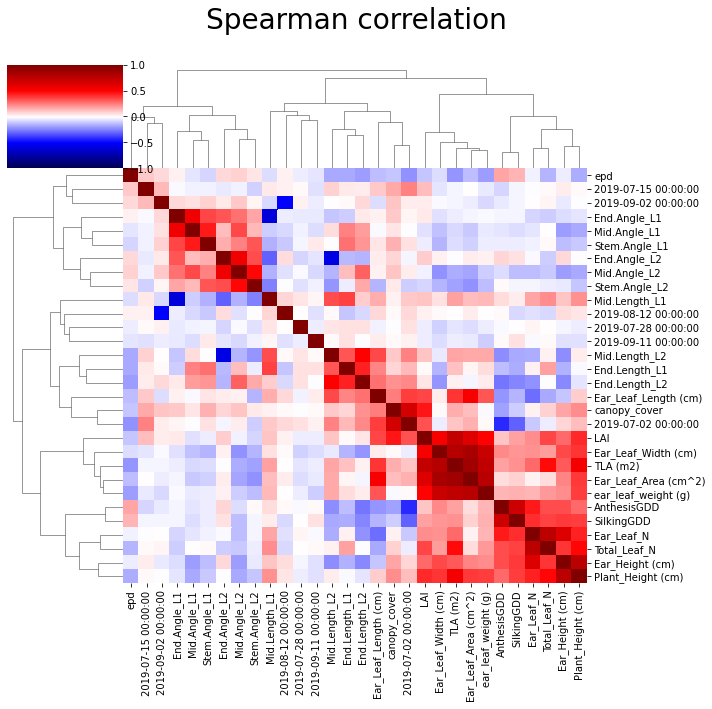

In [6]:
ss = [0] + list(range(10, 23)) + list(range(167, 178)) + list(range(187, 192))

sns.clustermap(scorr.iloc[ss, ss], method='complete', vmax=vmax, vmin=vmin, cmap=cmap);
plt.subplots_adjust(top=0.9)
plt.suptitle('Spearman correlation', fontsize=28);

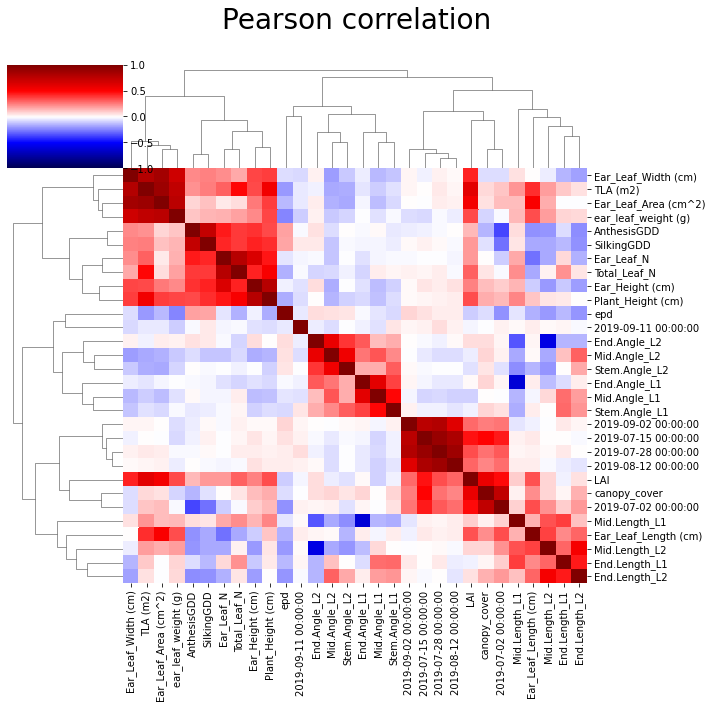

In [7]:
sns.clustermap(pcorr.iloc[ss,ss], method='complete', vmax=vmax, vmin=vmin, cmap=cmap);
plt.subplots_adjust(top=0.9)
plt.suptitle('Pearson correlation', fontsize=28);

# SVR: Predict canopy cover with a regression algorithm

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR, NuSVR
from sklearn.preprocessing import StandardScaler

In [9]:
cols = list(data.columns.values)
for i in range(len(cols)):
    print(i, '\t', cols[i])

0 	 plot
1 	 New_Source
2 	 New_Pedigree
3 	 Old_Pedigree
4 	 Old_Source
5 	 Shared
6 	 New_Family
7 	 Tester
8 	 Pass
9 	 Range
10 	 Group.1
11 	 Rep
12 	 Date.Time
13 	 Harvest.Sequence
14 	 X
15 	 Stand.Count
16 	 GreenSnap
17 	 Root Lodging
18 	 Stalk Lodging
19 	 canopy_cover
20 	 Weight
21 	 Moisture
22 	 Test.Weight
23 	 yield_originaal_moisture
24 	 yield_dry
25 	 yield_standard
26 	 yield_standard_bu
27 	 yield_dry_gm
28 	 dry_matter/plant(kg)
29 	 Ear_Leaf_Length (cm)
30 	 Ear_Leaf_Width (cm)
31 	 Ear_Leaf_Area (cm^2)
32 	 Ear_Height (cm)
33 	 Plant_Height (cm)
34 	 Ear_Leaf_N
35 	 Total_Leaf_N
36 	 AnthesisGDD
37 	 SilkingGDD
38 	 TLA (m2)
39 	 epd
40 	 ear_leaf_weight (g)
41 	 LAI
42 	 BLUE_2019702dronemean
43 	 BLUE_STD_2019702dronemean
44 	 GREEN_2019702dronemean
45 	 GREEN_STD_2019702dronemean
46 	 NDVI_2019702dronemean
47 	 NDVI_STD_2019702dronemean
48 	 NIR_2019702dronemean
49 	 NIR_STD_2019702dronemean
50 	 RED_2019702dronemean
51 	 RED_STD_2019702dronemean
52 	 RED_E

## Consider different collections of measurements

- **Traditional** (yield/harvest phenotypes ignored):
    - Stand.Count
    - GreenSnap
    - Ear Leaf length, width, area, weight
    - Ear and plant height
    - Ear leaf, and total leaf N
    - Anthesis and silking GDDs
    - TLA
    - EPD
    
    
- **Extended**: All traditional phenotypes plus angle and distance data for both L1 and L2 leafs (above, below ear respectively)


- **Model**: All traditional and extended phenotypes, plus polynomial model related data.


- **Drone**: All traditional data plus drone data.

All data was centered and scaled prior to any analysis.

In [10]:
cols = list(data.columns.values)
colss = cols[15:17] + cols[29:42]
colss += cols[192:197] + cols[206:211] 
#colss += cols[197:206] + cols[211:] 
#colss += cols[42:66]

pheno = data.loc[:, colss].copy()
pheno_scaled = StandardScaler().fit_transform(pheno)
print(pheno.shape)

(368, 25)


## Prediction target: canopy cover

**Two sources**: Drone and Undertaker


- In general, out-of-the-box regression algorithms work better whenever the target variable is normally distributed.

- The **drone canopy cover** seems to be normally distributed.

- The undertaker canopy cover doesn't seem to be normally distributed.


From now on, we will work exclusively with drone canopy cover data.

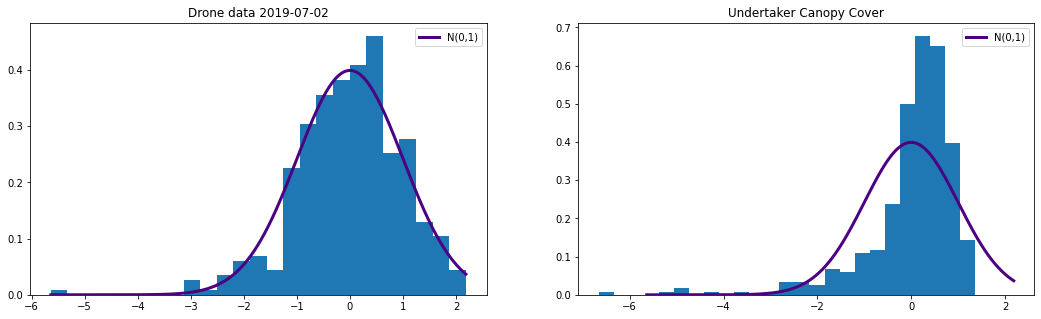

In [11]:
fig, ax = plt.subplots(1,2,figsize=(18,5))

y = data['2019-07-02 00:00:00'].values
y_scaled = (y - y.mean())/y.std()

gauss = stats.norm(0,1)
foo = np.linspace(y_scaled.min(),y_scaled.max(),1024)

ax[0].hist(y_scaled, 25, density=True);
ax[0].plot(foo,gauss.pdf(foo), c='indigo', label='N(0,1)', lw=3);
ax[0].set_title('Drone data 2019-07-02');
ax[0].legend();

y = data['canopy_cover'].values
y_scaled = (y - y.mean())/y.std()

ax[1].hist(y_scaled, 25, density=True);
ax[1].plot(foo,gauss.pdf(foo), c='indigo', label='N(0,1)', lw=3);
ax[1].set_title('Undertaker Canopy Cover');
ax[1].legend();

In [12]:
y = data['2019-07-02 00:00:00'].values
y_scaled = (y - y.mean())/y.std()

## SVR to predict canopy cover

- SVR is a supervised regression algorithm.

- Train with 50% of the data

- Predict the canopy cover of the other 50%

- Ideally, the predicted and actual canopy cover values should be the same, so their $R^2$ should be high.


The use of $\nu$-SVR limits the number of support vectors, which avoids overfitting.

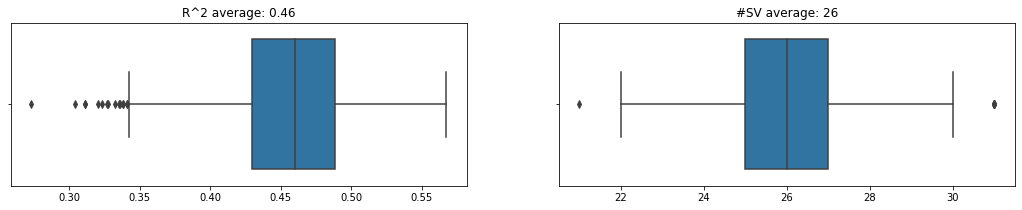

In [13]:
nusvr_params = {'kernel':'poly', 'C':10, 'gamma':0.001, 'degree':3, 'nu':0.1, 'coef0':1}

N = 1000
score = np.zeros(N)
supvecs = np.zeros(N)

for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(pheno_scaled, y_scaled, test_size=0.5)
    svr = NuSVR(**nusvr_params).fit(X_train, y_train)
    score[i] = svr.score(X_test, y_test)
    supvecs[i] = svr.n_support_[0]

fig, ax = plt.subplots(1,2,figsize=(18,3))

sns.boxplot(x=score, ax=ax[0]);
ax[0].set_title('R^2 average: {:.2f}'.format(np.mean(score)))
sns.boxplot(x=supvecs, ax=ax[1]);
ax[1].set_title('#SV average: {:.0f}'.format(np.round(np.mean(supvecs))));

## Results:

- **Traditional**: $R^2$ average of 0.48, while using 28 SVs


- **Extended**: $R^2$ average of 0.45, while using 26 SVs
 

- **Model**: $R^2$ average of 0.43, while using 30 SVs


- **Drone**: $R^2$ average of 0.70, while using 28 SVs

### Use 100% of data as both training and testing

The $R^2$ remains essentially the same

- **Traditional**: $R^2$ increases to 0.55, while using 12% of samples as SVs


- **Extended**: $R^2$ increases to 0.60 while using 16% of samples as SVs


- **Model**: $R^2$ increases to 0.63, but now we use 20% of samples as SVs.


- **Drone**: $R^2$ increases to 0.77, while using 18% of samples as SVs.

In [14]:
nusvr_params = {'kernel':'poly', 'C':1, 'gamma':0.01, 'degree':3, 'nu':0.1, 'coef0':1}
svr = NuSVR(**nusvr_params).fit(pheno_scaled, y_scaled)
print(np.around(svr.score(X_test, y_test), 3))
print(svr.n_support_[0])
print(np.around(svr.n_support_[0]/pheno_scaled.shape[0]*100, 2), '%')

0.561
60
16.3 %


## Conclusion

- Most of the predicting power comes from the traditional and drone-related phenotypes. 


- Although the $R^2$ increases when we take 100% of data as training, the number of support vectors increases as well. This suggests that the slight prediction power increases are due to overfitting, which is not desirable.

## Similar results when we use different SVR parameters

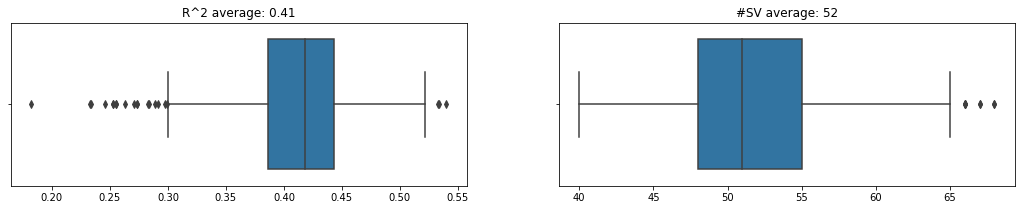

In [15]:
nusvr_params = {'C':10, 'kernel':'rbf', 'gamma':0.02, 'nu':.05}

N = 1000
score = np.zeros(N)
supvecs = np.zeros(N)

for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(pheno_scaled, y_scaled, test_size=0.5)
    svr = NuSVR(**nusvr_params).fit(X_train, y_train)
    score[i] = svr.score(X_test, y_test)
    supvecs[i] = svr.n_support_[0]

fig, ax = plt.subplots(1,2,figsize=(18,3))

sns.boxplot(x=score, ax=ax[0]);
ax[0].set_title('R^2 average: {:.2f}'.format(np.mean(score)))
sns.boxplot(x=supvecs, ax=ax[1]);
ax[1].set_title('#SV average: {:.0f}'.format(np.round(np.mean(supvecs))));

In [16]:
nusvr_params = {'C':10, 'kernel':'rbf', 'gamma':0.02, 'nu':.05}

svr = NuSVR(**nusvr_params).fit(pheno_scaled, y_scaled)
print(svr.score(X_test, y_test))
print(svr.n_support_[0])
print(np.around(svr.n_support_[0]/pheno_scaled.shape[0]*100, 2), '%')

0.6575631228364978
76
20.65 %


# Ridge Regression

- An unsupervised regression algorithm


- Ridge regression is not heavily affected by correlated data, since it assumes that just a handful of measurements do have large predicting power. 


- Thus, it discards most of the correlated data, and just keeps measurements that are truly different.


- We can also measure the **significance** or prediction power of each phenotype.

In [17]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

### Ridge regression with Cross Validation

- Use leave-one-out cross-validation to find the best $\alpha$ parameter

- $\alpha$ determines the penalty.
    - Low $\alpha$s imply that the ridge regression behaves similarly to a plain linear regression
    - High $\alpha$s imply that most of the measurements are being ignored.

In [32]:
clf = RidgeCV(np.linspace(1,100,50)).fit(pheno_scaled, y_scaled)
print('R^2 Score: ', np.around(clf.score(pheno_scaled, y_scaled),3))
print('alpha:', np.around(clf.alpha_,3))
coefsf = clf.coef_

R^2 Score:  0.593
alpha: 15.143


## Fit 100% of the data with ridge regression

- **Traditional**: $R^2=0.55$ with $\alpha=36.6$

- **Extended**: $R^2=0.59$ with $\alpha=15.1$

- **Model**: $R^2$ of 0.60 with $\alpha = 32.1$

- **Drone**: $R^2$ of 0.81 with $\alpha$ of 0.17.

In [33]:
argsort = np.argsort(np.abs(coefsf))[::-1]
vals = np.array(colss)[argsort]
coef = coefsf/np.sum(np.abs(coefsf))

## Sort by significance

- **Traditional**: Stand count, ear height, GDDs, and LAI very significant 


- **Extended**: The angle and distance measures do not add much to the ridge regression prediction 
    - Stand count, ear height, GDDs, and LAI very significant 
    - Mid.Length(L2) and End.Angle (L2) are the most significant phenotypes from the extended collection.


- **Model**: Polynomial model data doesn't add much to the picture either.
    - Stand count, ear height, GDDs, and LAI very significant again
    - $N_2$ (polynomial degree of the leaf from the apex to the tip) of $L1$ is the most significant model-related phenotype.
    - Mid.Length(L2) and Stem.Angle (L1) are the most significant phenotypes from the extended collection.


- **Drone**: Most of the prediction power comes from different wavelength measurements
    - Ear Leaf Width and Height are the most significant values outside the drone dataset

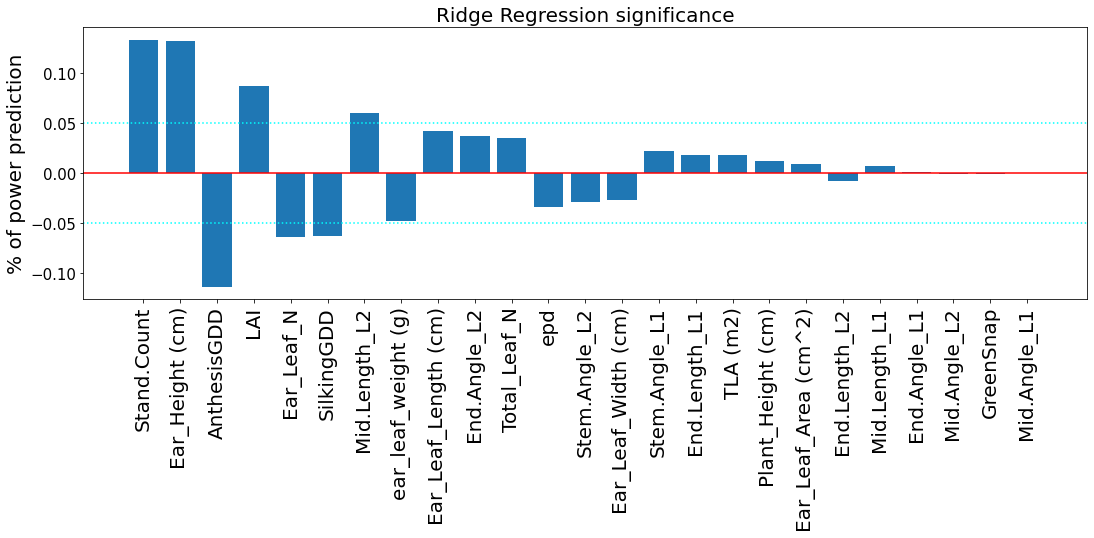

In [38]:
plt.figure(figsize=(18,5))
plt.bar(range(len(vals)), coef[argsort])
plt.axhline(0, c='red')
plt.axhline(0.05, c='cyan', ls=':')
plt.axhline(-0.05, c='cyan', ls=':')
plt.xticks(range(len(vals)), vals, rotation='vertical', fontsize=20);
plt.tick_params('y', labelsize=15);
plt.ylabel('% of power prediction', fontsize=20);
plt.title('Ridge Regression significance', fontsize=20)
plt.savefig(dst + 'ridge_extended.jpg', dpi=100, bbox_inches='tight')

## Take a supervised approach

Just like with SVR, take 50% as training and 50% as testing. This way we check if we are not overfitting.

- **Traditional**: $R^2=0.49$

- **Extended**: $R^2=0.51$

- **Model**: Average $R^2$ of 0.49

- **Drone**: Average $R^2$ of 0.74

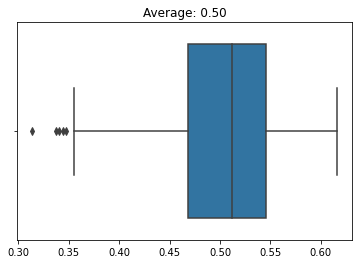

In [21]:
ridge_params = {'alpha':clf.alpha_, 'fit_intercept':False}

N = 1000
score = np.zeros(N)
coefs = np.zeros((N, len(colss)))

for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(pheno_scaled, y_scaled, test_size=0.5)
    clff = Ridge(**ridge_params).fit(X_train, y_train)
    score[i] = clff.score(X_test, y_test)
    coefs[i,:] = clff.coef_
    
ax = sns.boxplot(x=score)
ax.set_title('Average: {:.2f}'.format(np.mean(score)));

# Lasso regression

- Similar idea to ridge regression, except that now we explicitly force to **keep just a handful** of phenotypes with nonzero significance.


- Use cross-validation to find an optimal $\alpha$ penalty.

In [39]:
clf = LassoCV(alphas=np.linspace(0.009,1,50)).fit(pheno_scaled, y_scaled)
print('Score: ', np.around(clf.score(pheno_scaled, y_scaled),2))
print('alpha:', np.around(clf.alpha_,2))
coefsf = clf.coef_

Score:  0.59
alpha: 0.01


## Fit 100% of the data with ridge regression

- **Traditional**: $R^2=0.55$ with $\alpha=0.01$

- **Extended**: $R^2=0.59$ with $\alpha=0.01$

- **Model**: $R^2$ of 0.60 with $\alpha=0.01$


- **Drone**: $R^2$ of 0.77 with $\alpha$ of 0.01.

## Check non-zero significant phenotypes

- **Traditional**: Similar resulsts as with ridge regression

- **Extended**: Similar resulsts as with ridge regression

- **Model**: Similar resulsts as with ridge regression


- **Drone**: RED data is significant. 
    - Ear height, stand count, and LAI are significant as well

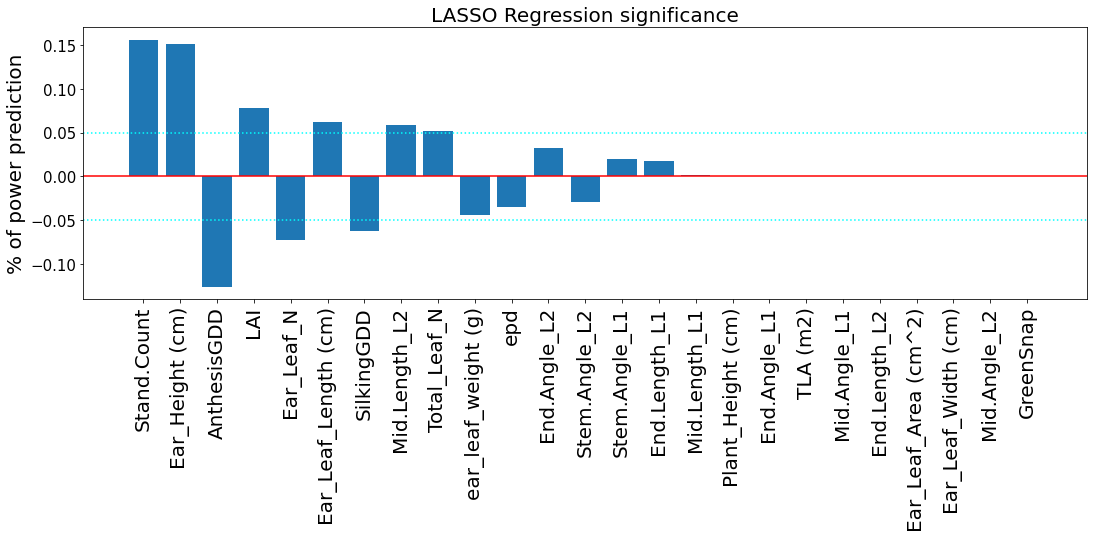

In [40]:
argsort = np.argsort(np.abs(coefsf))[::-1]
vals = np.array(colss)[argsort]
coef = coefsf/np.sum(np.abs(coefsf))

plt.figure(figsize=(18,5))
plt.bar(range(len(vals)), coef[argsort])
plt.axhline(0, c='red')
plt.axhline(0.05, c='cyan', ls=':')
plt.axhline(-0.05, c='cyan', ls=':')
plt.xticks(range(len(vals)), vals, rotation='vertical', fontsize=20);
plt.tick_params('y', labelsize=15);
plt.ylabel('% of power prediction', fontsize=20);
plt.title('LASSO Regression significance', fontsize=20)
plt.savefig(dst + 'lasso_extended.jpg', dpi=100, bbox_inches='tight')

## Supervised check

- **Traditional**: $R^2 = 0.48$
- **Extended**: $R^2 = 0.50$
- **Model**: Average $R^2 = 0.49$ 


- **Drone**: Average $R^2$ of 0.73.

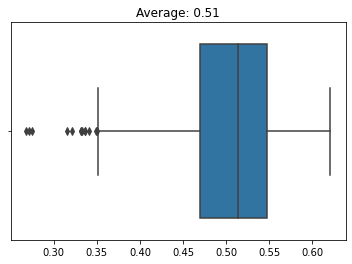

In [24]:
ridge_params = {'alpha':clf.alpha_, 'fit_intercept':False}

N = 1000
score = np.zeros(N)
coefs = np.zeros((N, len(colss)))

for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(pheno_scaled, y_scaled, test_size=0.5)
    clff = Lasso(**ridge_params).fit(X_train, y_train)
    score[i] = clff.score(X_test, y_test)
    coefs[i,:] = clff.coef_
    
ax = sns.boxplot(x=score)
ax.set_title('Average: {:.2f}'.format(np.mean(score)));

# PCA

In [25]:
y_var = (y - y.min())/(y.max() - y.min())

In [26]:
from sklearn.decomposition import PCA, KernelPCA

In [27]:
pca = PCA(n_components=2)
pca.fit(pheno_scaled)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.2131639  0.13280671]
[44.28439807 34.95456727]


In [28]:
prcomp = pca.transform(pheno_scaled)

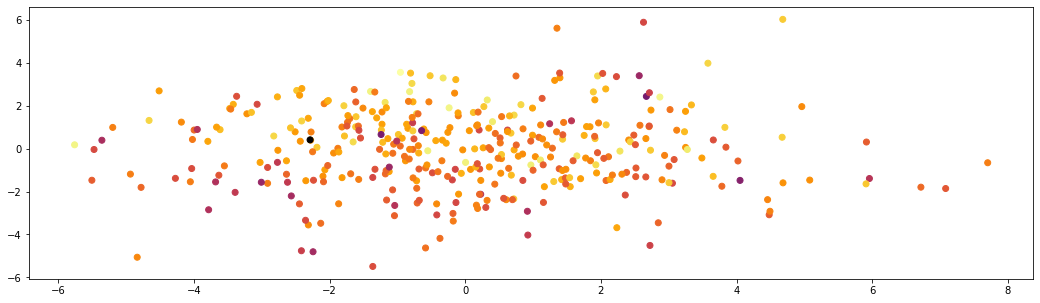

In [29]:
plt.figure(figsize=(18,5))

plt.scatter(prcomp[:,0], prcomp[:,1], c=y_var, cmap='inferno');

# KPCA

In [30]:
kpca = KernelPCA(n_components=2, kernel="rbf", fit_inverse_transform=False, gamma=0.01)
X_kpca = kpca.fit_transform(pheno_scaled)

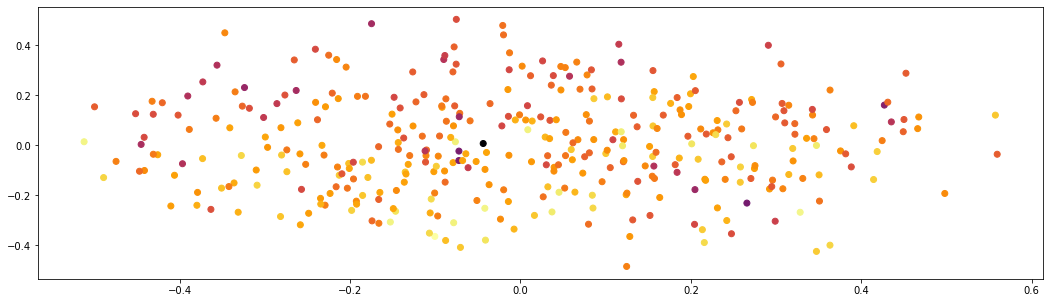

In [31]:
plt.figure(figsize=(18,5))

plt.scatter(X_kpca[:,0], X_kpca[:,1], c=y_var, cmap='inferno');